In [1]:
from maelzel.snd.audiosample import Sample
import numpy as np
import matplotlib.pyplot as plt
from maelzel.transcribe import mono
import logging
logger = logging.getLogger("maelzel")
logger.setLevel("DEBUG")

Sample(dur=10.74281179138322, sr=44100, ch=1)
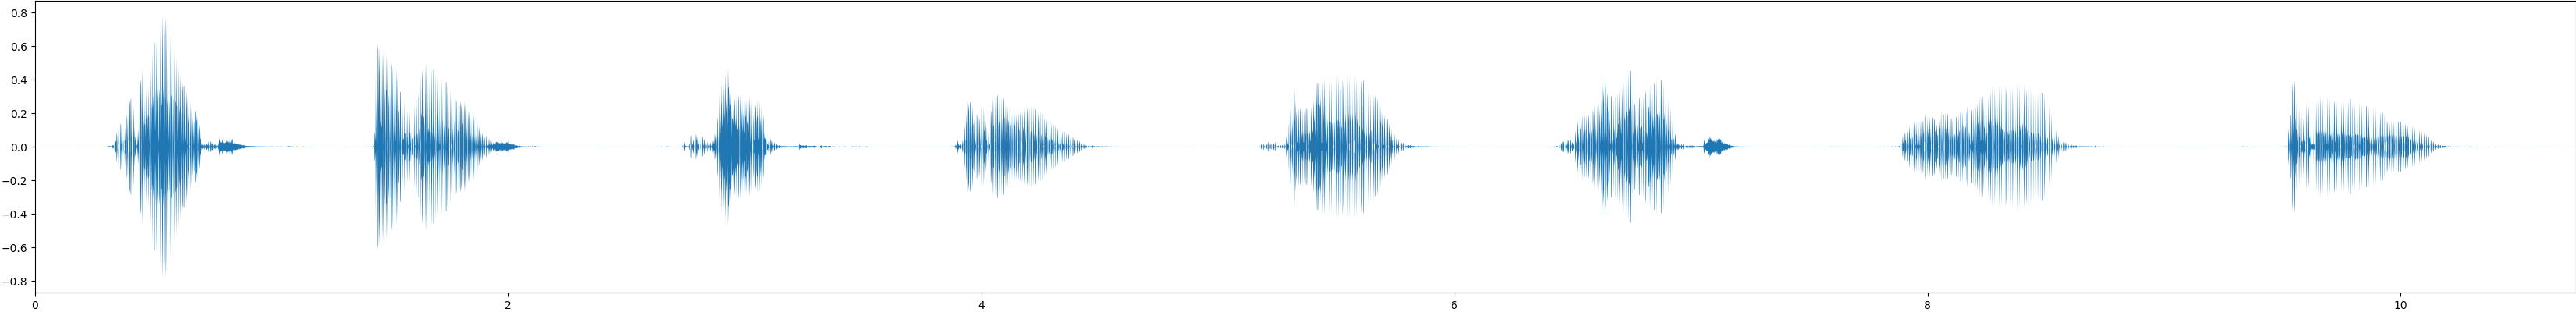

In [2]:
s = Sample("../snd/colours-german-male.flac")
s

LibXtract compiled with ooura FFT


mnOut size: 926
m_pitchTrack size: 926


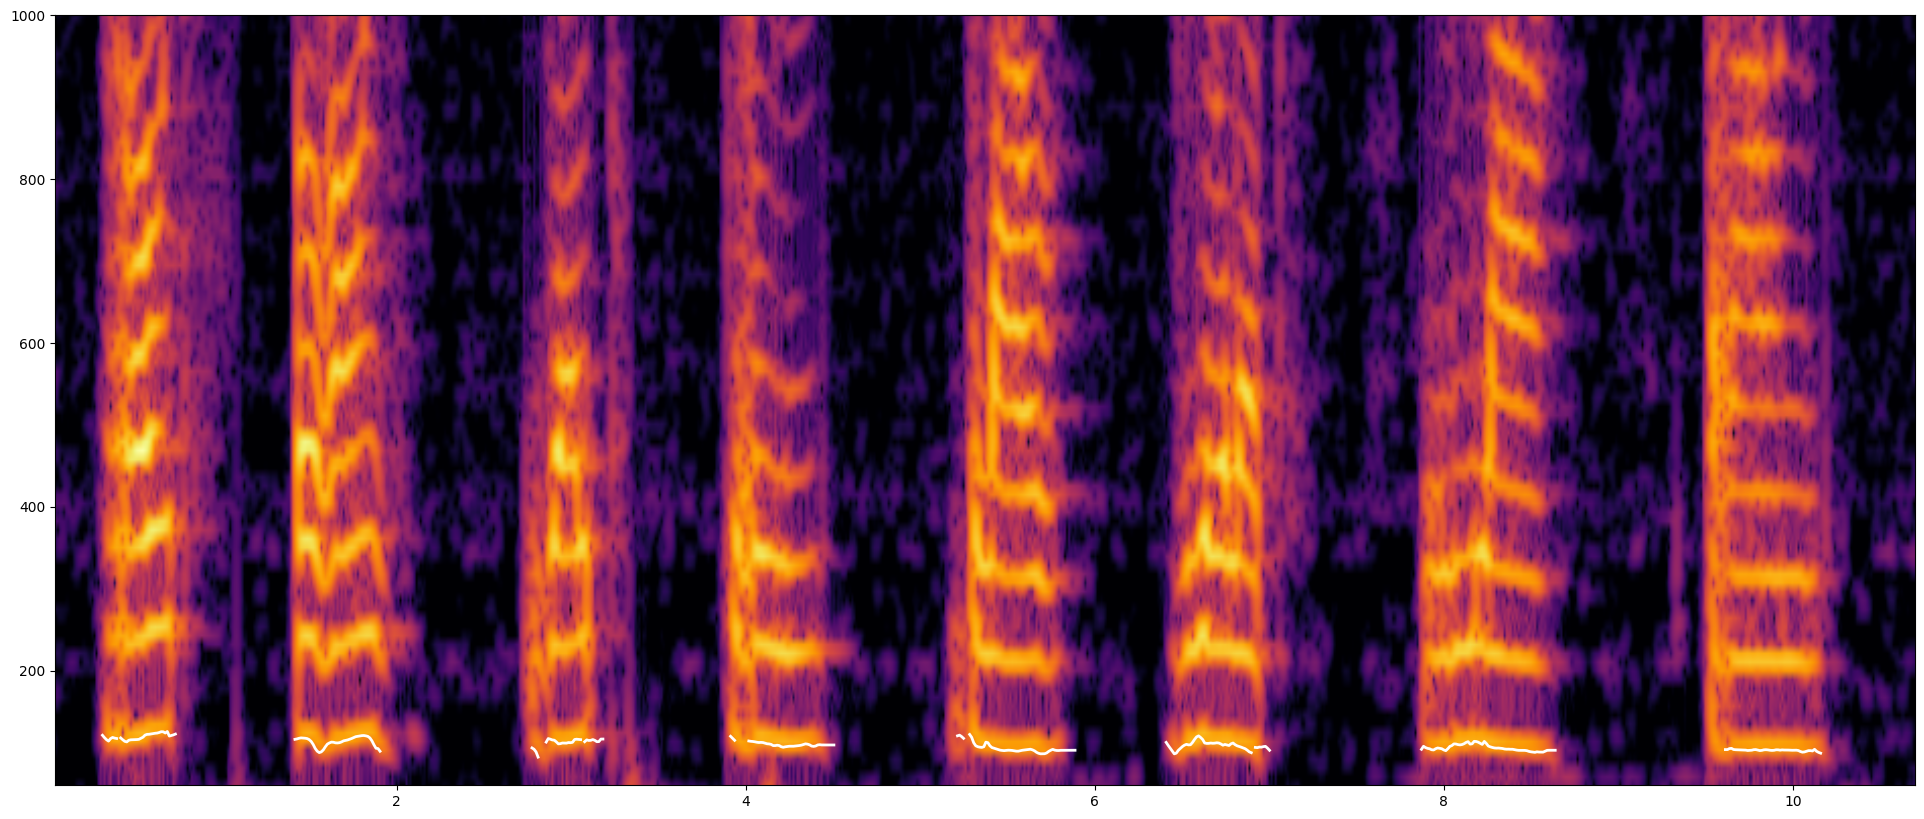

In [3]:
f0times, f0freqs = s.fundamental(unvoiced='nan', overlap=4, minAmpDb=-60, sensitivity=0.1)
ampbpf = s.amplitudeBpf()
amps = ampbpf.map(f0times)

# Remove unvoiced parts
voiced = f0freqs.copy()
voiced[f0freqs < 0] = float('nan')

axes = s.plotSpectrogram(minfreq=60, maxfreq=1000, fftsize=4096, overlap=8)
axes.plot(f0times, voiced, linewidth=2, color='#ffffff')

Play the fundamental together with the soundfile to validate the tracking

In [4]:
import csoundengine as ce
session = ce.Session()


using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


In [5]:
session.defInstr('vco', r'''
  |kfreq=1000, kamp=0.1|
  kfreq2 init 1000
  kamp2 init 1
  koff = kfreq < 0 ? 1 : 0
  kfreq2 = kfreq > 0 ? kfreq : kfreq2
  kamp2 = kfreq > 0 ? kamp : 0
  aamp = lag(interp(kamp2), 0.05)
  
  asig = vco2:a(1, kfreq2) * aamp
  asig *= linsegr:a(0, 0.05, 1, 0.05, 0)
  outch 1, asig
''')

Instr(vco, kfreq=1000, kamp=0.1)

In [6]:
# amps = (f0freqs > 0) * 0.1

with session:
    # Using the session as a context manager ensures that the events
    # scheduled are in sync
    session.playSample((s.samples, s.sr), pan=1, delay=0.05)
    vco = session.sched('vco', dur=s.duration)
    vco.automate('kamp', (f0times, amps))
    vco.automate('kfreq', (f0times, f0freqs))
session
    

Button(description='Stop Synths', style=ButtonStyle())

Output()

Session(engine0, backend=jack, outdev=Built-in Audio Analog Stereo, synths=2)

In [7]:
f0anal = s.fundamentalAnalysis()

mnOut size: 1851
m_pitchTrack size: 1851


<Axes: >

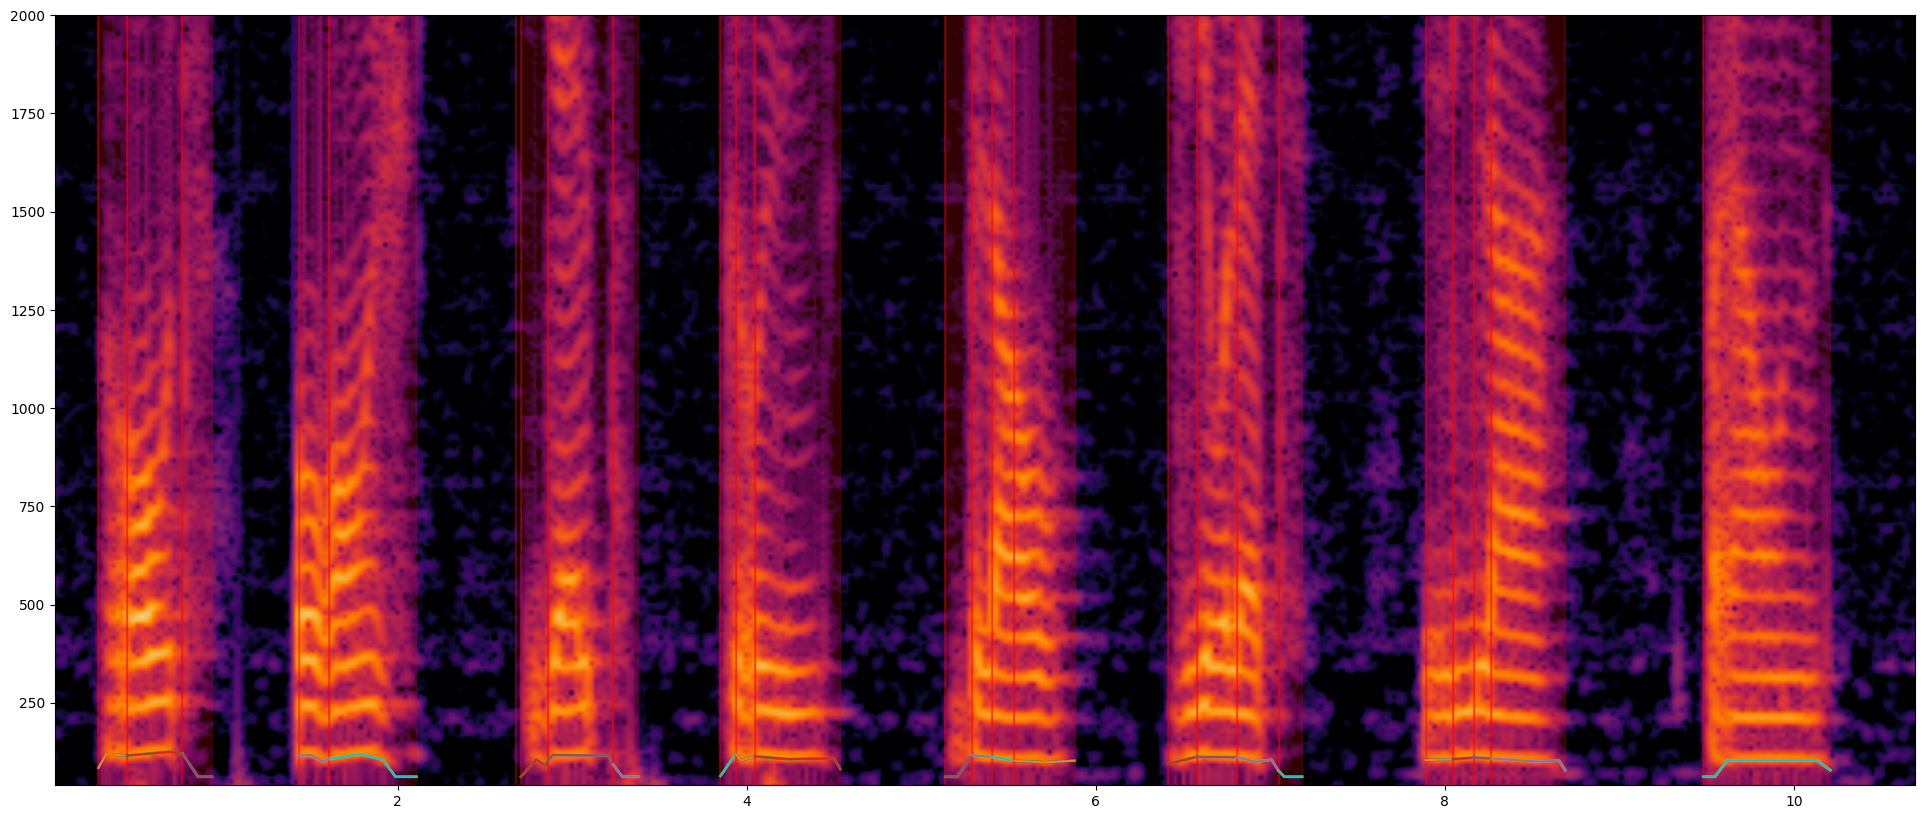

In [8]:
%matplotlib inline
axes = s.plotSpectrogram(maxfreq=2000, fftsize=4096)
f0anal.plot(axes=axes)


## Sample 2

In [9]:
from maelzel.snd import filters
s2 = Sample("../snd/piano-pitchtest-Cmaj.flac")
# samples = filters.spectralFilter(s2.samples, sr=s2.sr, pairs=[0, 0, 250, 0, 260, 1, 24000, 1])
samples = s2.samples
s2f0 = mono.FundamentalAnalysisMonophonic(samples=samples, sr=s2.sr, removeSustain=True, simplify=0.00, onsetThreshold=0.05, minFrequency=200, lowAmpSuppression=0.005)

mnOut size: 1781
m_pitchTrack size: 1781


Sample(dur=10.429433106575964, sr=44100, ch=1)
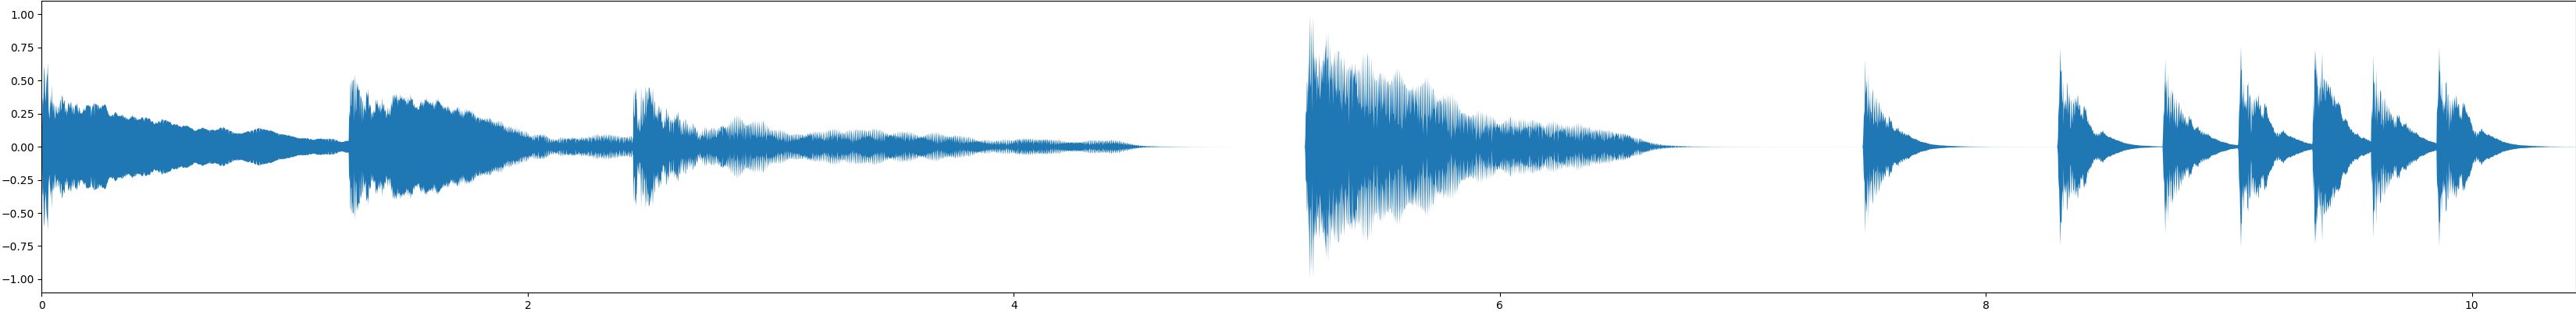

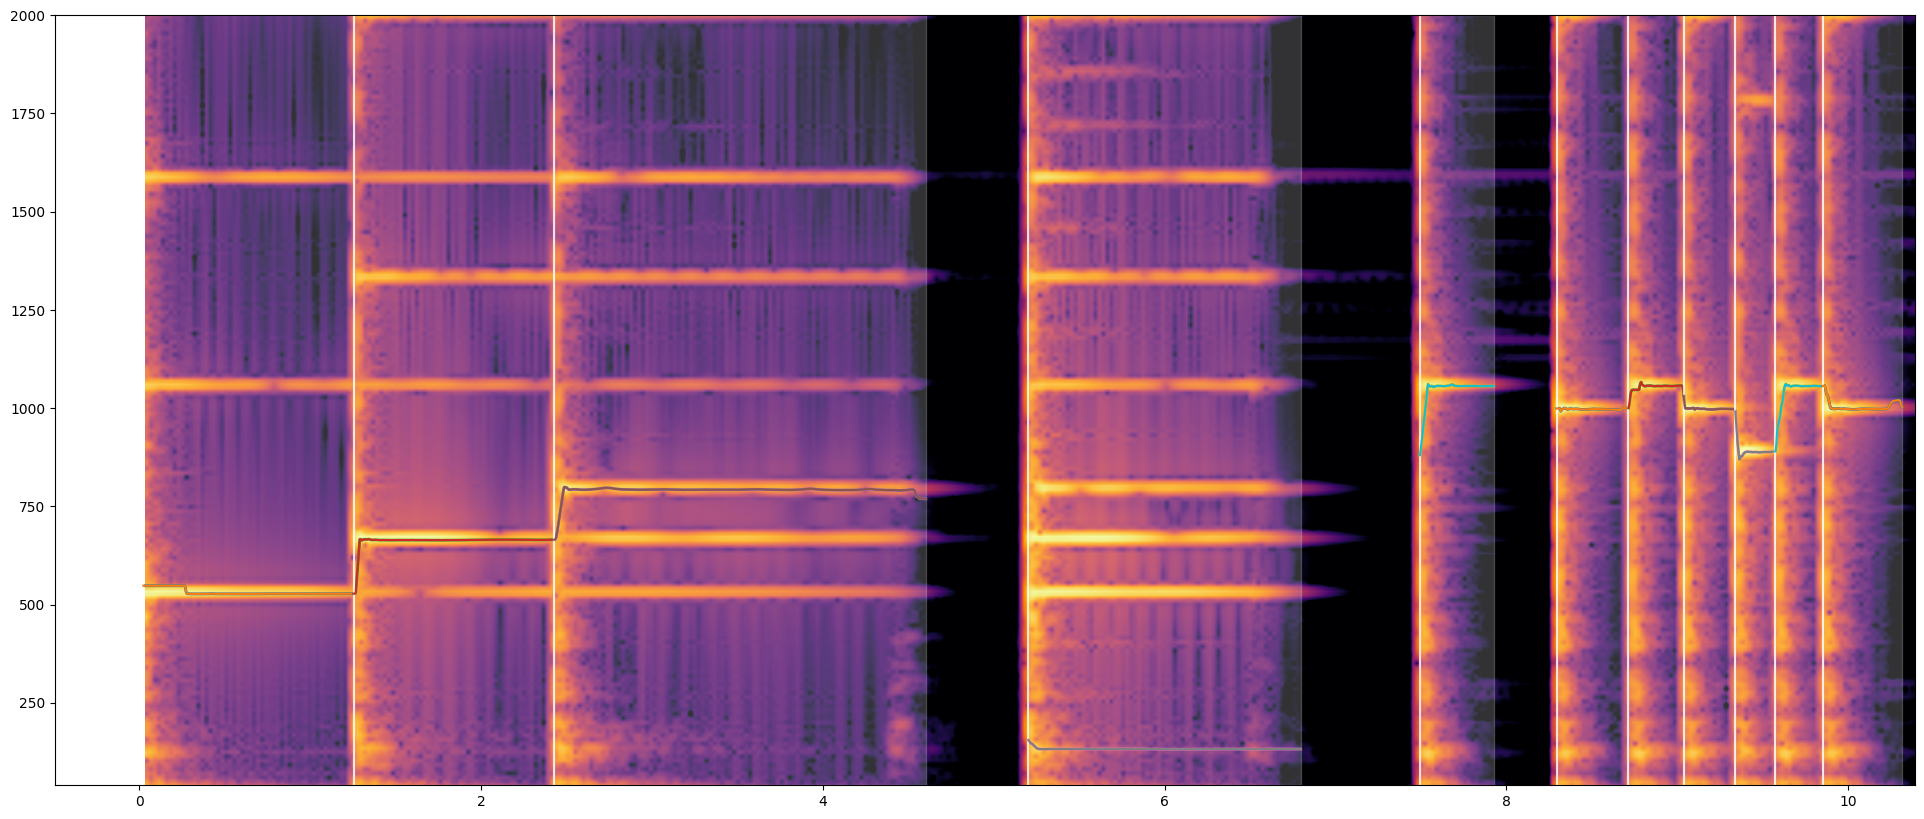

In [10]:
%matplotlib inline
axes = Sample(samples, s2.sr).plotSpectrogram(maxfreq=2000, fftsize=4096)
s2f0.plot(axes=axes, spanAlpha=0.2, onsetAlpha=0.8, spanColor='#ffffff')
s2